# Integrals

This is a notebook that focuses on some additional documentation for the computational integration performed to obtain observables through the Green's function. Thankfully, we do not need to run the full BdG code (e.g. self-consistency), so we may dive right in.

In [1]:
import numpy as np

# To have access to tsc module
import sys
import os

# Get the grandparent directory of the current working directory
gparent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
# Append the parent directory to the PYTHONPATH
sys.path.append(gparent_dir)

from tsc.utilities import get_int_mesh

## T = 0 case

The function that creates the energy mesh for the integrations depends on the temperature. More specifically, it is different for $T = 0$ and $T > 0$. Let's first see the $T = 0$ case, i.e. when the Fermi-Dirac function corresponds to a step-function.

In [2]:
Es, Ws = get_int_mesh(T=0.0, N_1=10, N_2=50, N_3=10, J=6, E_min = -5.0, E_max = 0.0, k_B=1.0)

First of all, note that the function above does not only return energy values, but also integration weights. This is because we are using a Gaussian quadrature procedure to calculate the desired integrals. In general, we approximate the desired integral as

$$
\int_{-1}^{1}{f\left(x\right)dx} \approx \sum_{i=1}^{n}{w_if\left(x_i\right)},
$$

where the nodes, $x_i$, and weights, $w_i$, depend on the type of chosen quadrature.

The function above for $T = 0$ explicitly uses Gauss-Legendre quadrature, where the $i$-th node corresponds to the $i$-th root of $P_n$, where $P_n$ is the $n$-th Legendre polynomial normalized to give $P_n(1) = 1$. The corresponding weights are given by the formula

$$
w_i = \frac{2}{\left(1-x_i^2\right)\left[P_n^\prime\left(x_i\right)\right]^2}.
$$

Note that the integral above is calculated from $-1$ to $1$. To change the interval to $\left[a,b\right]$ we must perform the change of variable

$$
x = \frac{b-a}{2}t + \frac{a+b}{2},
$$

which yields the following approximation:

$$
\int_{a}^{b}{f\left(x\right)dx} \approx \frac{b-a}{2}\sum_{i=1}^{n}{w_i f\left(\frac{b-a}{2}t_i + \frac{a+b}{2}\right)}.
$$

For the implementation of Gauss-Legendre quadrature we use the `numpy.polynomial.legendre.leggauss` function which we import as `GAULEG`, to remind us of the corresponding juKKR codebase's naming conventions.

Let us now focus on the energy mesh alone. If we depict it via a scatter plot, we get the following figure.

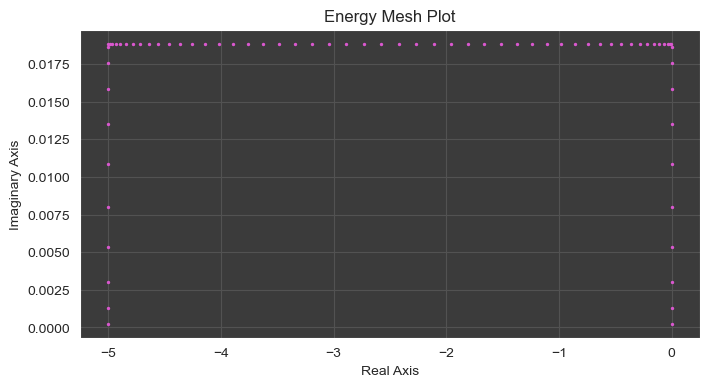

In [3]:
from plotting import plot_contour

plot_contour(Es)

It appears that the energy mesh corresponds to a path that consists of three lines: 

- A line from $E_\textrm{min} + \textrm{i}\eta$ to $E_\textrm{min} + 2\textrm{i}J\eta$ (up line) where $N_1$ points are chosen.
- A line from $E_\textrm{min} + 2\textrm{i}J\eta$ to $E_\textrm{max} + 2\textrm{i}J\eta$ (right line) where $N_2$ points are chosen.
- A line from $E_\textrm{max} + 2\textrm{i}J\eta$ to $E_\textrm{max} + \textrm{i}\eta$ (down line) where $N_3$ points are chosen.

The total number of integration points is $N_1 + N_2 + N_3$. Let's make a few comments before moving on. First of all, $\eta$ corresponds to a "small" value, which is taken here to be equal to $\pi*k_B*T_\textrm{eff}$, where we choose $T_\textrm{eff} = 5\cdot 10^{-4}$. Secondly, $J$ is an integer which has no physical significance in the case $T = 0$, other than deciding "how much upwards from the horizontal axis we must go". Finally, in theory we should have $E_\textrm{min} = -\infty$ and $E_\textrm{max} = \infty$, but we practically care about energies where the Green's function is not effectively zero (e.g. above the valence band and below the Fermi level).

Why a contour in the first place? Well, the real axis contains all of the Green's function's poles, therefore they should be avoided by a small imaginary displacement as follows:

$$
\int_{-\infty}^{\infty}{H\left(\epsilon\right)G\left(\epsilon\right)d\epsilon} = \lim_{\eta \to 0}\int_{-\infty + \textrm{i}\eta}^{\infty + \textrm{i}\eta}{H\left(z\right)G\left(z\right)dz},
$$

where $H\left(\epsilon\right)$ is a simple step-function in place of the Fermi-Dirac function and $z = \epsilon + \textrm{i}\eta$. Even in this case, calculating this integral would require a rather dense mesh, because of the heavy spikes of the Green's function near its poles. As a result, for purely computational reasons, we may turn to Cauchy's Residue Theorem to help us calculate the integrals faster (i.e. by selecting fewer integration points) without compromising on accuracy.

Now, if we denote our selected path by $\mathcal{P}$, then $\mathcal{P}$ along with the line from $\infty + \textrm{i}\eta$ to $-\infty + \textrm{i}\eta$ (pay attention to the signs) closes the path, transforming it into a contour that wraps no poles (since the step function has no poles and all of the poles of the Green's function lie on the real axis). This implies that the closed contour integral is equal to zero and we may therefore schematically write

$$
\oint{\dots} = \int_{\mathcal{P}}{\dots} + \int_{\infty + \textrm{i}\eta}^{-\infty + \textrm{i}\eta}{\dots} = \int_{\mathcal{P}}{\dots} - \int_{-\infty + \textrm{i}\eta}^{\infty + \textrm{i}\eta}{\dots} = 0,
$$

which means that the previous equation can now be written as

$$
\int_{-\infty}^{\infty}{H\left(\epsilon\right)G\left(\epsilon\right)d\epsilon} = \lim_{\eta \to 0}\int_{\mathcal{P}}{H\left(z\right)G\left(z\right)dz}.
$$

## T > 0 case

What about the case when $T > 0$ and therefore the Fermi-Dirac function does not correspond to a step function? Well, in this case we must make a few changes regarding both our mesh and our choice of quadrature.

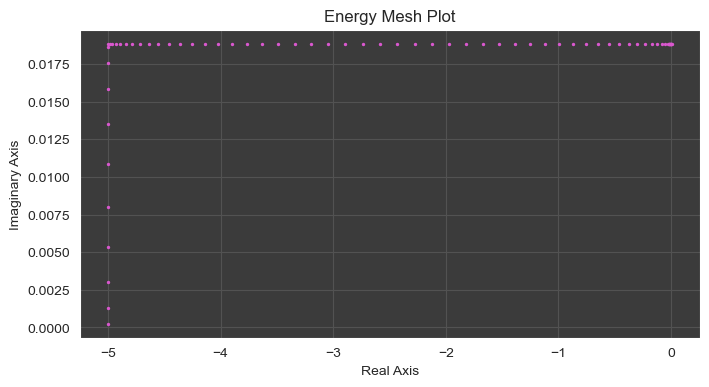

In [15]:
Es, Ws = get_int_mesh(T=5e-4, N_1=10, N_2=50, N_3=10, J=6, E_min = -5.0, E_max = 0.0, k_B=1.0)

plot_contour(Es[:-6]) # 6 corresponds to the value of J

In this case, we have:

- A line from $E_\textrm{min} + \textrm{i}\eta$ to $E_\textrm{min} + 2\textrm{i}J\eta$ (up line) where $N_1$ points are chosen.
- A line from $E_\textrm{min} + 2\textrm{i}J\eta$ to $E_\textrm{max} - 30k_BT + 2\textrm{i}J\eta$ (first right line) where $N_2$ points are chosen.
- A line from $E_\textrm{max} + 2\textrm{i}J\eta$ to $E_\textrm{max} + 30k_BT + 2\textrm{i}J\eta$ (second right line) where $N_3$ points are chosen.

First of all, why is there no "down" line in this case? Well, there actually is one down line, however it is far away, near $\infty$ and its contribution is practically equal to zero. Of course, the horizontal line does not extend all the way to actual infinity, but stops near $E_\textrm{max} + 30k_BT$. However, adding a fourth line that goes down from this point would lead to wrong results, because of how near this vertical line would be to the line that contains the Matsubara frequencies 

In [18]:
# say what J is now

# TODO: CONTINUE

As we can see, the mesh corresponds to lines that try to avoid the horizontal axis because of the poles that exist on the energy axis for the Green's function. If we denote this arc by $\mathcal{C}$, the reasoning behind using it is the following. First of all, the horizontal axis integral can be "avoided" by a small imaginary displacement as follows:




Additionally, the contour integral that consists of $\mathcal{C}$ and the horizontal line (supposing a clockwise direction) is equal to the residues by the poles of the Fermi-Dirac function, i.e. the fermionic Matsubara frequencies, according to Cauchy's Residue Theorem:

$$
\oint{f\left(z\right)G\left(z\right)dz} = 2\textrm{i}\pi k_BT\sum_{n}{G\left(\textrm{i}\Omega_n\right)},
$$

where $\Omega_n = \left(2n+1\right)\pi k_BT$.

Finally, we may schematically write

$$
\oint{\dots} = \int_{\mathcal{C}}{\dots} - \int_{-\infty + \textrm{i}\eta}^{\infty + \textrm{i}\eta}{\dots} 
$$

Combining all of these, we have

$$
\int_{-\infty}^{\infty}{f\left(\epsilon\right)G\left(\epsilon\right)d\epsilon} = \lim_{\eta \to 0}\int_{\mathcal{C}}{f\left(z\right)G\left(z\right)dz} - 2\textrm{i}\pi k_BT\sum_{n}{G\left(\textrm{i}\Omega_n\right)}
$$

# TODO: SPEAK ABOUT HOW MATSUBARA POLES ARE CALCULATED AS ES AND WEIGHTS

# Maybe add stuff for DoS?